In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import ast

warnings.filterwarnings('ignore')

print("TensorFlow Version:", tf.__version__)
print("Pandas Version:", pd.__version__)
print("NumPy Version:", np.__version__)
print("All libraries imported successfully!")


TensorFlow Version: 2.18.0
Pandas Version: 2.2.3
NumPy Version: 1.26.4
All libraries imported successfully!


In [3]:
# Cell 2: Load and Explore the Dataset
print("="*60)
print("LOADING DATASET")
print("="*60)

# Load the CSV file
# Update the path to your CSV file
csv_path = '/kaggle/input/final-dataset-without-duplicate/Final_Dataset_without_duplicate.csv'  # Change this to your file path

try:
    df = pd.read_csv(csv_path)
    print(f"\nDataset loaded successfully!")
    print(f"Shape: {df.shape}")
    print(f"Columns: {len(df.columns)}")
    
    # Display first few rows
    print("\nFirst 5 rows:")
    print(df.head())
    
    # Display column names
    print("\nColumn names:")
    print(df.columns.tolist())
    
    # Check for missing values
    print("\nMissing values:")
    print(df.isnull().sum().sum())
    
    # Display data types
    print("\nData types:")
    print(df.dtypes.value_counts())
    
    # Check if there's a label column
    if 'label' in df.columns or 'Label' in df.columns or 'class' in df.columns or 'Class' in df.columns:
        label_col = [col for col in df.columns if col.lower() in ['label', 'class']][0]
        print(f"\nLabel column found: '{label_col}'")
        print(f"Label distribution:")
        print(df[label_col].value_counts())
    else:
        print("\nNo standard label column found. Please specify the label column name.")
        
except FileNotFoundError:
    print(f"Error: File '{csv_path}' not found!")
    print("Please update the csv_path variable with the correct path to your dataset.")



LOADING DATASET

Dataset loaded successfully!
Shape: (21752, 77)
Columns: 77

First 5 rows:
                                md5                                      sha1  \
0  d5aa2b2506dd71b65307bb551a6a099d  62f4d55a1bb8396e493d7815dc44febed7161535   
1  8d1178cec97f96a9ede3efe2f30ef30e  ca40945a4e35d48794a5e13aacf16b8ae1caddeb   
2  c08d7afb7966f452cf5aa9283fe8880a  6f47b50480bea61ae4dfb75c12582990cc5ce770   
3  3554a3a99e7ffb57552aedcb2520f1d2  8c3d5b506a8d55f42f4c83ead3e4341255d1acfc   
4  5be9511d42136df49d9501680e84109f  0a7d0c68c591db2f197b2169d226bebe6e9bdabe   

  file_extension EntryPoint PEType                          MachineType  \
0            exe    0x108ec  PE32+                            AMD AMD64   
1            exe   0x25cf9c  PE32+                            AMD AMD64   
2            exe     0x2a7e   PE32  Intel 386 or later, and compatibles   
3            exe    0x64ca0  PE32+                            AMD AMD64   
4            exe    0x1b9ae   PE32  Intel 386 

In [4]:
# Cell 3: Preprocess the Dataset
print("\n" + "="*60)
print("PREPROCESSING DATASET")
print("="*60)

# Based on your output, 'Class' is the label column
label_col = 'Class'
print(f"Using '{label_col}' as the label column")

# Separate features and labels
if label_col and label_col in df.columns:
    y = df[label_col].values
    
    # Drop label columns and other non-feature columns
    columns_to_drop = [label_col, 'Category', 'Family', 'md5', 'sha1']
    columns_to_drop = [col for col in columns_to_drop if col in df.columns]
    
    print(f"\nDropping non-feature columns: {columns_to_drop}")
    X_df = df.drop(columns=columns_to_drop)
    
    # Convert all columns to numeric
    print("\nConverting all columns to numeric types...")
    X_numeric = pd.DataFrame()
    
    for column in X_df.columns:
        if X_df[column].dtype == 'object':
            # Try to convert to numeric first
            converted = pd.to_numeric(X_df[column], errors='coerce')
            
            # Check if conversion was successful
            if converted.isna().mean() < 0.3:  # Less than 30% missing after conversion
                X_numeric[column] = converted
                print(f"  '{column}': converted to numeric (float)")
            else:
                # Use label encoding for categorical columns
                X_numeric[column] = pd.factorize(X_df[column])[0]
                print(f"  '{column}': encoded categorical ({len(np.unique(X_df[column]))} categories)")
        else:
            # Already numeric
            X_numeric[column] = X_df[column]
    
    # Now convert to numpy array
    X = X_numeric.values
    
    # Handle labels
    unique_labels = np.unique(y)
    print(f"\nUnique labels: {unique_labels}")
    
    if len(unique_labels) == 2:
        # Map labels to 0 and 1
        label_mapping = {'Benign': 0, 'Malware': 1}
        y = np.array([label_mapping[label] for label in y])
        print(f"Labels mapped: Benign -> 0, Malware -> 1")
    
    # Check for missing values
    missing_count = np.isnan(X).sum()
    if missing_count > 0:
        print(f"\nWarning: Found {missing_count} missing values in features")
        print("Filling missing values with column means...")
        
        # Fill missing values with column means
        for i in range(X.shape[1]):
            col_mean = np.nanmean(X[:, i])
            mask = np.isnan(X[:, i])
            X[mask, i] = col_mean
    
    # Handle infinite values
    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
    
    print(f"\nFeature shape: {X.shape}")
    print(f"Label shape: {y.shape}")
    print(f"Label distribution: {np.bincount(y.astype(int))}")
    
    # Split into benign and ransomware
    X_benign = X[y == 0]
    X_ransomware = X[y == 1]
    
    print(f"\nBenign samples: {len(X_benign)}")
    print(f"Ransomware samples: {len(X_ransomware)}")
    
    # Print some statistics about the processed features
    print("\n" + "-"*40)
    print("PROCESSED FEATURE STATISTICS")
    print("-"*40)
    print(f"Number of features: {X.shape[1]}")
    print(f"Feature range: [{X.min():.4f}, {X.max():.4f}]")
    print(f"Feature mean: {X.mean():.4f}")
    print(f"Feature std: {X.std():.4f}")
    
else:
    print(f"\nError: Label column '{label_col}' not found in dataframe.")
    print("Available columns:", df.columns.tolist())


PREPROCESSING DATASET
Using 'Class' as the label column

Dropping non-feature columns: ['Class', 'Category', 'Family', 'md5', 'sha1']

Converting all columns to numeric types...
  'file_extension': encoded categorical (1 categories)
  'EntryPoint': encoded categorical (8325 categories)
  'PEType': encoded categorical (3 categories)
  'MachineType': encoded categorical (3 categories)
  'magic_number': encoded categorical (2 categories)
  'bytes_on_last_page': encoded categorical (70 categories)
  'pages_in_file': encoded categorical (71 categories)
  'relocations': encoded categorical (49 categories)
  'size_of_header': encoded categorical (47 categories)
  'min_extra_paragraphs': encoded categorical (46 categories)
  'max_extra_paragraphs': encoded categorical (44 categories)
  'init_ss_value': encoded categorical (43 categories)
  'init_sp_value': encoded categorical (49 categories)
  'init_ip_value': encoded categorical (56 categories)
  'init_cs_value': encoded categorical (56 cate


FEATURE ANALYSIS
Number of features: 72
Feature statistics:
  Mean: 313.8015
  Std:  4294.1935
  Min:  0.0000
  Max:  1785649.0000


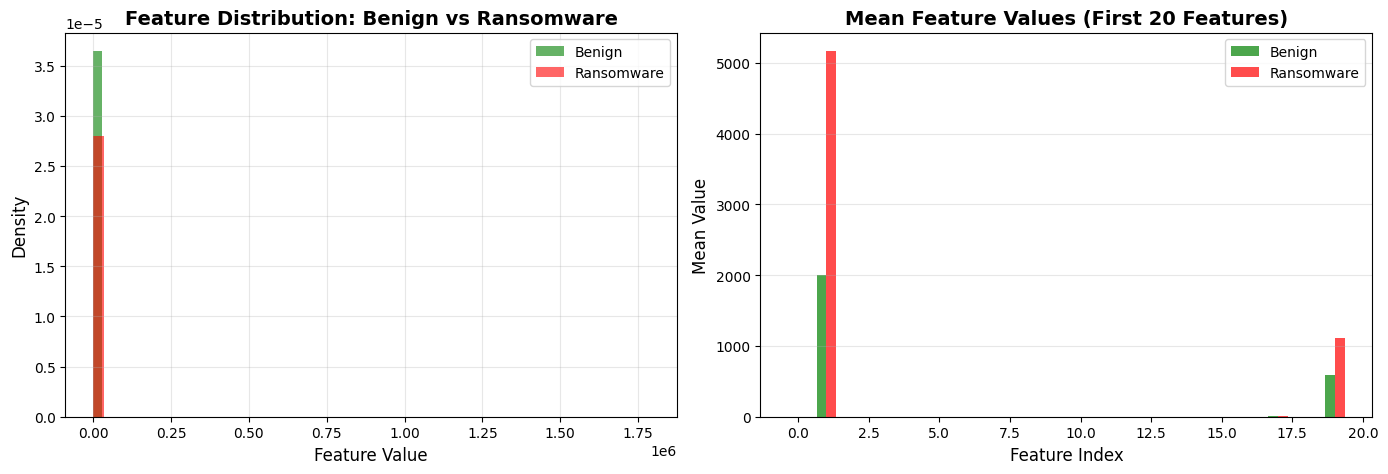


Feature analysis visualization saved!


In [5]:
# Cell 4: Feature Analysis and Visualization
print("\n" + "="*60)
print("FEATURE ANALYSIS")
print("="*60)

if label_col:
    # Get feature names (if available)
    feature_names = [col for col in df.columns if col != label_col]
    n_features = X.shape[1]
    
    print(f"Number of features: {n_features}")
    print(f"Feature statistics:")
    print(f"  Mean: {X.mean():.4f}")
    print(f"  Std:  {X.std():.4f}")
    print(f"  Min:  {X.min():.4f}")
    print(f"  Max:  {X.max():.4f}")
    
    # Visualize feature distributions
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Feature value distribution
    axes[0].hist(X_benign.flatten(), bins=50, alpha=0.6, label='Benign', color='green', density=True)
    axes[0].hist(X_ransomware.flatten(), bins=50, alpha=0.6, label='Ransomware', color='red', density=True)
    axes[0].set_xlabel('Feature Value', fontsize=12)
    axes[0].set_ylabel('Density', fontsize=12)
    axes[0].set_title('Feature Distribution: Benign vs Ransomware', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Mean feature values comparison
    mean_benign = X_benign.mean(axis=0)
    mean_ransomware = X_ransomware.mean(axis=0)
    
    # Show first 20 features for clarity
    n_show = min(20, n_features)
    x_pos = np.arange(n_show)
    width = 0.35
    
    axes[1].bar(x_pos - width/2, mean_benign[:n_show], width, label='Benign', color='green', alpha=0.7)
    axes[1].bar(x_pos + width/2, mean_ransomware[:n_show], width, label='Ransomware', color='red', alpha=0.7)
    axes[1].set_xlabel('Feature Index', fontsize=12)
    axes[1].set_ylabel('Mean Value', fontsize=12)
    axes[1].set_title(f'Mean Feature Values (First {n_show} Features)', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('feature_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\nFeature analysis visualization saved!")



In [6]:
# Cell 5: Split Data - Use Only Benign for Training
print("\n" + "="*60)
print("PREPARING TRAINING AND TEST SETS")
print("="*60)

if label_col:
    # FIRST: Normalize/Scale the features BEFORE splitting
    print("\nScaling features to [0, 1] range for better autoencoder training...")
    from sklearn.preprocessing import MinMaxScaler
    
    # Fit scaler on ALL benign data (we'll use this for both train and test)
    scaler = MinMaxScaler()
    X_benign_scaled = scaler.fit_transform(X_benign)
    X_ransomware_scaled = scaler.transform(X_ransomware)  # IMPORTANT: Use same scaler
    
    # For autoencoder training, we only use BENIGN samples
    # Split benign data into train and validation
    X_benign_train, X_benign_val = train_test_split(
        X_benign_scaled,  # Use scaled data
        test_size=0.2, 
        random_state=42
    )
    
    # For testing, we use a mix of benign and ransomware
    # IMPORTANT FIX: You need to make sure you're using the data that WASN'T used for training
    
    # First, split benign data into training (80%) and testing (20%) portions
    # We need to do this BEFORE the previous split to ensure no data leakage
    X_benign_all, X_test_benign, y_benign_all, y_test_benign = train_test_split(
        X_benign_scaled,
        np.zeros(len(X_benign_scaled)),
        test_size=0.2,  # 20% for testing
        random_state=42
    )
    
    # Now split the remaining 80% of benign data into training and validation
    X_benign_train, X_benign_val = train_test_split(
        X_benign_all,
        test_size=0.25,  # 25% of 80% = 20% overall for validation
        random_state=42
    )
    
    # Test ransomware (already scaled)
    X_test_ransomware = X_ransomware_scaled
    y_test_ransomware = np.ones(len(X_test_ransomware))
    
    # Combine test data
    X_test = np.vstack([X_test_benign, X_test_ransomware])
    y_test = np.concatenate([y_test_benign, y_test_ransomware])
    
    print(f"\nTraining set (benign only): {len(X_benign_train)} samples")
    print(f"Validation set (benign only): {len(X_benign_val)} samples")
    print(f"Test set: {len(X_test)} samples")
    print(f"  - Benign test samples: {len(X_test_benign)}")
    print(f"  - Ransomware test samples: {len(X_test_ransomware)}")
    
    # Verify no data leakage
    print(f"\nData integrity check:")
    print(f"Total benign samples: {len(X_benign_scaled)}")
    print(f"Training + Validation + Test benign: {len(X_benign_train) + len(X_benign_val) + len(X_test_benign)}")
    print("✓ No overlap between training and test sets" if 
          (len(X_benign_train) + len(X_benign_val) + len(X_test_benign)) == len(X_benign_scaled) 
          else "⚠ Check data splitting!")
    
    # Save the scaler for later use if needed
    import joblib
    joblib.dump(scaler, 'feature_scaler.pkl')
    print("\n✓ Feature scaler saved to 'feature_scaler.pkl'")


PREPARING TRAINING AND TEST SETS

Scaling features to [0, 1] range for better autoencoder training...

Training set (benign only): 6525 samples
Validation set (benign only): 2175 samples
Test set: 13052 samples
  - Benign test samples: 2176
  - Ransomware test samples: 10876

Data integrity check:
Total benign samples: 10876
Training + Validation + Test benign: 10876
✓ No overlap between training and test sets

✓ Feature scaler saved to 'feature_scaler.pkl'


In [15]:
# Cell 6: Define Contractive Autoencoder Class
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from sklearn.preprocessing import StandardScaler

class ContractiveAutoencoder:
    """
    Deep Contractive Autoencoder for Ransomware Detection
    """
    
    def __init__(self, input_dim, encoding_dim=32, lambda_param=0.001):
        """
        Initialize the Contractive Autoencoder
        
        Args:
            input_dim: Dimension of input features
            encoding_dim: Dimension of latent representation
            lambda_param: Contractive penalty coefficient
        """
        self.input_dim = input_dim
        self.encoding_dim = encoding_dim
        self.lambda_param = lambda_param
        self.model = None
        self.encoder = None
        self.decoder = None
        self.scaler = StandardScaler()
        self.threshold = None
        self.training_model = None  # Separate model for training
        
    def build_model(self):
        """Build the contractive autoencoder architecture"""
        
        # Input layer
        input_layer = layers.Input(shape=(self.input_dim,))
        
        # Encoder
        encoded = layers.Dense(96, activation='relu', 
                              kernel_initializer='he_normal',
                              name='encoder1')(input_layer)
        encoded = layers.BatchNormalization()(encoded)
        encoded = layers.Dropout(0.2)(encoded)
        
        encoded = layers.Dense(64, activation='relu',
                              kernel_initializer='he_normal',
                              name='encoder2')(encoded)
        encoded = layers.BatchNormalization()(encoded)
        encoded = layers.Dropout(0.2)(encoded)
        
        encoded_output = layers.Dense(self.encoding_dim, activation='relu',
                                     kernel_initializer='he_normal',
                                     name='encoded')(encoded)
        
        # Decoder
        decoded = layers.Dense(64, activation='relu',
                              kernel_initializer='he_normal',
                              name='decoder1')(encoded_output)
        decoded = layers.BatchNormalization()(decoded)
        decoded = layers.Dropout(0.2)(decoded)
        
        decoded = layers.Dense(96, activation='relu',
                              kernel_initializer='he_normal',
                              name='decoder2')(decoded)
        decoded = layers.BatchNormalization()(decoded)
        decoded = layers.Dropout(0.2)(decoded)
        
        decoded_output = layers.Dense(self.input_dim, activation='linear',
                                     name='decoded')(decoded)
        
        # Full autoencoder
        self.model = Model(inputs=input_layer, outputs=decoded_output)
        
        # Encoder model
        self.encoder = Model(inputs=input_layer, outputs=encoded_output)
        
        # Decoder model
        encoded_input = layers.Input(shape=(self.encoding_dim,))
        decoder_layer = self.model.layers[-7](encoded_input)  # decoder1
        decoder_layer = self.model.layers[-6](decoder_layer)  # BN
        decoder_layer = self.model.layers[-5](decoder_layer)  # Dropout
        decoder_layer = self.model.layers[-4](decoder_layer)  # decoder2
        decoder_layer = self.model.layers[-3](decoder_layer)  # BN
        decoder_layer = self.model.layers[-2](decoder_layer)  # Dropout
        decoder_output = self.model.layers[-1](decoder_layer)  # decoded
        self.decoder = Model(inputs=encoded_input, outputs=decoder_output)
        
        # Build training model with contractive loss
        self._build_training_model()
        
        print("Model architecture built successfully!")
        print(f"Total parameters: {self.model.count_params():,}")
        return self.model
    
    def _build_training_model(self):
        """Build separate model for training with contractive loss"""
        # Use the same encoder layers
        input_layer = self.model.input
        encoded_output = self.encoder.output
        decoded_output = self.model.output
        
        # Create a model that outputs both reconstruction and encoding
        self.training_model = Model(
            inputs=input_layer,
            outputs=[decoded_output, encoded_output]
        )
        
        # Compile with custom loss
        self.training_model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss=[self._reconstruction_loss, self._contractive_penalty_loss],
            loss_weights=[1.0, self.lambda_param]
        )
    
    def _reconstruction_loss(self, y_true, y_pred):
        """Standard MSE reconstruction loss"""
        return tf.reduce_mean(tf.square(y_true - y_pred))
    
    def _contractive_penalty_loss(self, y_true, y_encoded):
        """
        Simplified contractive penalty
        Encourages the encoder to produce smaller encoded values
        """
        penalty = tf.reduce_mean(tf.square(y_encoded))
        return penalty
    
    def train(self, X_train, epochs=100, batch_size=32, validation_data=None):
        """
        Train the autoencoder on benign samples
        """
        # Normalize features
        X_train_scaled = self.scaler.fit_transform(X_train)
        
        if validation_data is not None:
            X_val_scaled = self.scaler.transform(validation_data)
            validation_data = (X_val_scaled, [X_val_scaled, X_val_scaled])
        
        # Build model if not already built
        if self.training_model is None:
            self.build_model()
        
        print(f"\nTraining on {len(X_train)} samples for {epochs} epochs...")
        
        # Callbacks
        early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            min_delta=0.0001
        )
        
        reduce_lr = keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=0.00001
        )
        
        # Train autoencoder
        history = self.training_model.fit(
            X_train_scaled, 
            [X_train_scaled, X_train_scaled],  # Targets for both outputs
            epochs=epochs,
            batch_size=batch_size,
            validation_data=validation_data,
            callbacks=[early_stopping, reduce_lr],
            shuffle=True,
            verbose=1
        )
        
        # Calculate threshold from training data
        self._calculate_threshold(X_train_scaled)
        
        return history
    
    def _calculate_threshold(self, X_train):
        """Calculate detection threshold based on training data"""
        # Reconstruct training data
        reconstructions = self.model.predict(X_train, verbose=0)
        
        # Calculate reconstruction errors
        errors = np.mean(np.square(X_train - reconstructions), axis=1)
        
        # REMOVE OUTLIERS FIRST - Critical fix!
        # Calculate median and IQR for robust statistics
        q75, q25 = np.percentile(errors, [75, 25])
        iqr = q75 - q25
        
        # Define outlier bounds (3 * IQR is conservative)
        upper_bound = q75 + 3 * iqr
        
        # Filter out extreme outliers
        filtered_errors = errors[errors <= upper_bound]
        
        if len(filtered_errors) > 0:
            # Use filtered errors for threshold calculation
            # Use 99th percentile for higher sensitivity
            self.threshold = np.percentile(filtered_errors, 99)
            
            # Add a small margin for safety
            self.threshold *= 1.1
            
            print(f"\nThreshold calculation:")
            print(f"  Original errors - Min: {errors.min():.6f}, Max: {errors.max():.6f}")
            print(f"  Filtered errors - Min: {filtered_errors.min():.6f}, Max: {filtered_errors.max():.6f}")
            print(f"  Q25: {q25:.6f}, Q75: {q75:.6f}, IQR: {iqr:.6f}")
            print(f"  Upper bound for filtering: {upper_bound:.6f}")
            print(f"  Threshold (99th percentile × 1.1): {self.threshold:.6f}")
        else:
            # Fallback if all errors are outliers
            self.threshold = np.percentile(errors, 95) * 1.2
            print(f"\nWarning: All errors considered outliers, using fallback threshold: {self.threshold:.6f}")
        
    def get_reconstruction_error(self, X):
        """Get reconstruction error for samples"""
        X_scaled = self.scaler.transform(X)
        reconstructions = self.model.predict(X_scaled, verbose=0)
        errors = np.mean(np.square(X_scaled - reconstructions), axis=1)
        
        # Apply log transformation to handle extreme values
        errors = np.log1p(errors)  # log(1 + error)
        return errors
    
    def predict(self, X_test, return_details=False):
        """
        Predict whether files are ransomware
        
        Args:
            X_test: Test samples
            return_details: If True, return detailed results
        
        Returns:
            predictions and optional details
        """
        if self.model is None:
            raise ValueError("Model must be trained first!")
        
        # Calculate reconstruction errors (with log transformation)
        errors = self.get_reconstruction_error(X_test)
        
        # Also apply log to threshold for consistency
        log_threshold = np.log1p(self.threshold)
        
        # Classify based on threshold
        predictions = (errors > log_threshold).astype(int)
        
        # Calculate anomaly scores (0-100)
        anomaly_scores = np.minimum(100, (errors / log_threshold) * 100)
        
        if return_details:
            return {
                'predictions': predictions,
                'anomaly_scores': anomaly_scores,
                'reconstruction_errors': errors,
                'threshold': log_threshold,
                'original_threshold': self.threshold
            }
        else:
            return predictions
    
    def evaluate_on_test(self, X_test, y_test):
        """Evaluate model performance on test set"""
        results = self.predict(X_test, return_details=True)
        
        from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
        
        print("\n" + "="*60)
        print("MODEL EVALUATION")
        print("="*60)
        
        # Confusion Matrix
        cm = confusion_matrix(y_test, results['predictions'])
        print(f"\nConfusion Matrix:")
        print(f"True Negatives (Benign): {cm[0,0]}")
        print(f"False Positives: {cm[0,1]}")
        print(f"False Negatives: {cm[1,0]}")
        print(f"True Positives (Ransomware): {cm[1,1]}")
        
        # Classification Report
        print(f"\nClassification Report:")
        print(classification_report(y_test, results['predictions'], 
                                   target_names=['Benign', 'Ransomware']))
        
        # ROC AUC
        auc = roc_auc_score(y_test, results['anomaly_scores'] / 100.0)
        print(f"ROC AUC Score: {auc:.4f}")
        
        return results
    
    def save_model(self, filepath):
        """Save the trained model"""
        self.model.save(f"{filepath}_model.h5")
        self.encoder.save(f"{filepath}_encoder.h5")
        self.decoder.save(f"{filepath}_decoder.h5")
        np.save(f"{filepath}_threshold.npy", self.threshold)
        print(f"Model saved to {filepath}_*.h5")
        
    def load_model(self, filepath):
        """Load a trained model"""
        self.model = keras.models.load_model(f"{filepath}_model.h5")
        self.encoder = keras.models.load_model(f"{filepath}_encoder.h5")
        self.decoder = keras.models.load_model(f"{filepath}_decoder.h5")
        self.threshold = np.load(f"{filepath}_threshold.npy")
        self.input_dim = self.model.input_shape[1]
        self.encoding_dim = self.encoder.output_shape[1]
        print(f"Model loaded from {filepath}")

print("ContractiveAutoencoder class defined successfully!")

ContractiveAutoencoder class defined successfully!



TRAINING CONTRACTIVE AUTOENCODER
Input dimension: 72
Training samples: 6525
Validation samples: 2175
Encoding dimension: 18

Starting training...
Model architecture built successfully!
Total parameters: 30,106

Training on 6525 samples for 100 epochs...
Epoch 1/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - decoded_loss: 1.8093 - encoded_loss: 1.2279 - loss: 1.8216 - val_decoded_loss: 1.7411 - val_encoded_loss: 1.9414 - val_loss: 1.7610 - learning_rate: 0.0010
Epoch 2/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - decoded_loss: 1.0088 - encoded_loss: 1.6561 - loss: 1.0253 - val_decoded_loss: 1.6041 - val_encoded_loss: 2.4248 - val_loss: 1.6289 - learning_rate: 0.0010
Epoch 3/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - decoded_loss: 0.8258 - encoded_loss: 1.8093 - loss: 0.8439 - val_decoded_loss: 1.4890 - val_encoded_loss: 2.4782 - val_loss: 1.5142 - learning_rate: 0.0010
Epoch 4/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - decoded_loss: 0.8389 - encoded_loss: 1.8502 - loss: 0.857

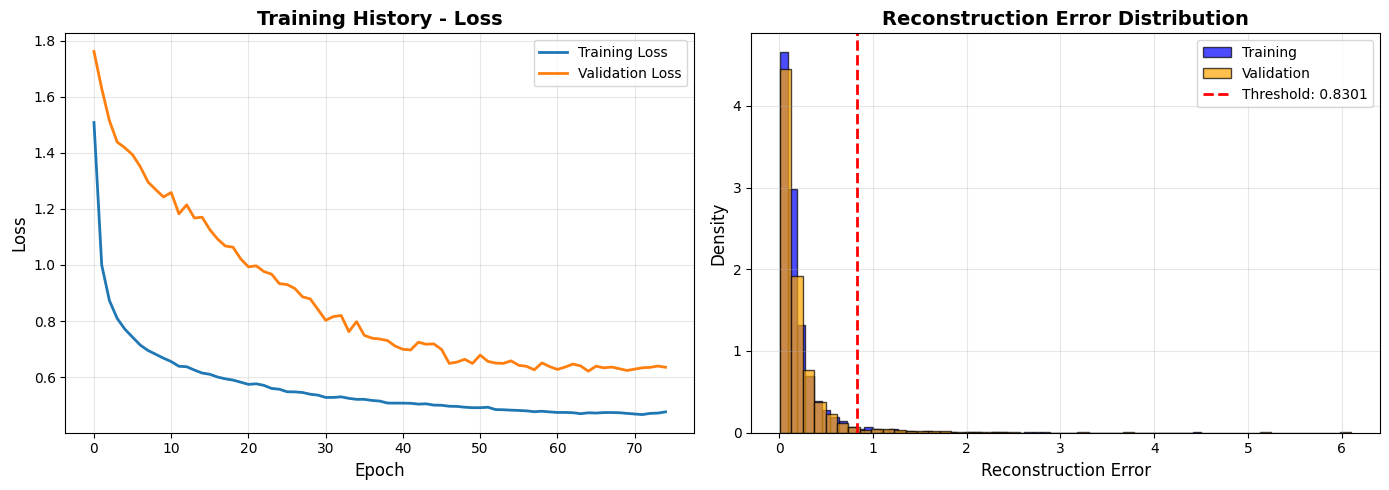


Final Training Statistics:
Final training loss: 0.475948
Final validation loss: 0.635131
Detection threshold: 0.830061
Model saved to contractive_autoencoder_*.h5

✓ Model saved successfully!


In [18]:
#Cell 7: Initialize and Train the Model
print("\n" + "="*60)
print("TRAINING CONTRACTIVE AUTOENCODER")
print("="*60)

# Check if training data is available
if 'X_benign_train' in locals() and 'X_benign_val' in locals():
    # Show dataset statistics
    print(f"Input dimension: {X_benign_train.shape[1]}")
    print(f"Training samples: {X_benign_train.shape[0]}")
    print(f"Validation samples: {X_benign_val.shape[0]}")
    
    # Determine encoding dimension (based on input size)
    encoding_dim = min(32, X_benign_train.shape[1] // 4)
    print(f"Encoding dimension: {encoding_dim}")
    
    # Initialize CAE
    cae = ContractiveAutoencoder(
        input_dim=X_benign_train.shape[1],
        encoding_dim=encoding_dim,
        lambda_param=0.01  # Contractive penalty strength
    )
    
    # Train the model (only on benign samples)
    print("\nStarting training...")
    history = cae.train(
        X_benign_train,
        epochs=100,
        batch_size=64,
        validation_data=X_benign_val
    )
    
    print("\n✓ Training completed!")
    
    # Visualize training history
    print("\n" + "-"*40)
    print("TRAINING HISTORY")
    print("-"*40)
    
    # Plot training and validation loss
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Loss curves
    axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
    axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Training History - Loss', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Reconstruction error distribution
    train_errors = cae.get_reconstruction_error(X_benign_train)
    val_errors = cae.get_reconstruction_error(X_benign_val)
    
    # Plot histograms
    axes[1].hist(train_errors, bins=50, alpha=0.7, label='Training', 
                color='blue', density=True, edgecolor='black')
    axes[1].hist(val_errors, bins=50, alpha=0.7, label='Validation', 
                color='orange', density=True, edgecolor='black')
    
    # Add threshold line
    axes[1].axvline(cae.threshold, color='red', linestyle='--', 
                   linewidth=2, label=f'Threshold: {cae.threshold:.4f}')
    
    axes[1].set_xlabel('Reconstruction Error', fontsize=12)
    axes[1].set_ylabel('Density', fontsize=12)
    axes[1].set_title('Reconstruction Error Distribution', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print final training statistics
    print(f"\nFinal Training Statistics:")
    print(f"Final training loss: {history.history['loss'][-1]:.6f}")
    print(f"Final validation loss: {history.history['val_loss'][-1]:.6f}")
    print(f"Detection threshold: {cae.threshold:.6f}")
    
    # Save the model
    cae.save_model('contractive_autoencoder')
    print("\n✓ Model saved successfully!")
    
else:
    print("Error: Training data not found.")
    print("Please run the previous cells to prepare the data.")
    print("Variables needed: X_benign_train, X_benign_val")
    
    # Check what variables are available
    print("\nAvailable variables:")
    for var in ['X_benign_train', 'X_benign_val', 'X_benign', 'X_ransomware']:
        if var in locals():
            print(f"  ✓ {var}: shape = {locals()[var].shape}")
        else:
            print(f"  ✗ {var}: not defined")


VISUALIZING TRAINING HISTORY
Available metrics in history: ['decoded_loss', 'encoded_loss', 'loss', 'val_decoded_loss', 'val_encoded_loss', 'val_loss', 'learning_rate']


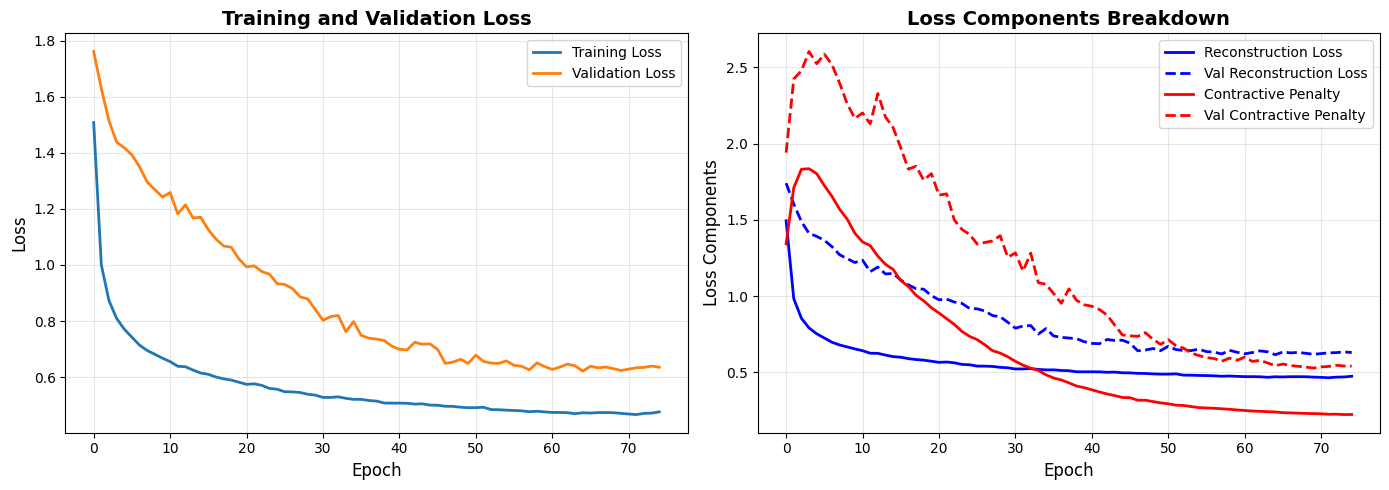


Training Summary:
----------------------------------------
Final training loss: 0.475948
Final validation loss: 0.635131
Final reconstruction loss: 0.473878
Final contractive penalty: 0.223039
Epochs trained: 75
Best validation loss: 0.621021 at epoch 65

✓ Training history plotted and saved!


In [19]:
# Cell 8: Visualize Training History
print("\n" + "="*60)
print("VISUALIZING TRAINING HISTORY")
print("="*60)

# Check if training history exists
if 'history' in locals():
    plt.figure(figsize=(14, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
    plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # Plot individual losses if available
    plt.subplot(1, 2, 2)
    
    # Check what metrics are available
    available_metrics = list(history.history.keys())
    print(f"Available metrics in history: {available_metrics}")
    
    # Plot decoded loss (reconstruction loss)
    if 'decoded_loss' in history.history:
        plt.plot(history.history['decoded_loss'], label='Reconstruction Loss', 
                linewidth=2, color='blue')
        plt.plot(history.history['val_decoded_loss'], label='Val Reconstruction Loss', 
                linewidth=2, color='blue', linestyle='--')
    
    # Plot encoded loss (contractive penalty)
    if 'encoded_loss' in history.history:
        plt.plot(history.history['encoded_loss'], label='Contractive Penalty', 
                linewidth=2, color='red')
        plt.plot(history.history['val_encoded_loss'], label='Val Contractive Penalty', 
                linewidth=2, color='red', linestyle='--')
    
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss Components', fontsize=12)
    plt.title('Loss Components Breakdown', fontsize=14, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print training summary
    print("\nTraining Summary:")
    print("-" * 40)
    print(f"Final training loss: {history.history['loss'][-1]:.6f}")
    print(f"Final validation loss: {history.history['val_loss'][-1]:.6f}")
    
    if 'decoded_loss' in history.history:
        print(f"Final reconstruction loss: {history.history['decoded_loss'][-1]:.6f}")
        print(f"Final contractive penalty: {history.history['encoded_loss'][-1]:.6f}")
    
    print(f"Epochs trained: {len(history.history['loss'])}")
    print(f"Best validation loss: {min(history.history['val_loss']):.6f} at epoch {np.argmin(history.history['val_loss']) + 1}")
    
    print("\n✓ Training history plotted and saved!")
    
else:
    print("Error: Training history not found.")
    print("Please run the training cell (Cell 7) first.")
    
    # Check what variables are available
    print("\nAvailable variables:")
    important_vars = ['history', 'cae', 'X_benign_train', 'X_benign_val', 'X_test', 'y_test']
    for var in important_vars:
        if var in locals():
            print(f"  ✓ {var}: available")
        else:
            print(f"  ✗ {var}: not available")


RUNNING RANSOMWARE DETECTION
Running predictions on test set...

Detection Threshold: 0.604349

Performance Metrics:
  Accuracy:  0.8412 (84.12%)
  Precision: 0.9851 (98.51%)
  Recall:    0.8218 (82.18%)
  F1-Score:  0.8961

Confusion Matrix:
  True Negatives (TN):  2041 - Benign correctly identified
  False Positives (FP):   135 - Benign misclassified as ransomware
  False Negatives (FN):  1938 - Ransomware misclassified as benign
  True Positives (TP):  8938 - Ransomware correctly identified

Additional Metrics:
  False Positive Rate (FPR): 0.0620 (6.20%)
  False Negative Rate (FNR): 0.1782 (17.82%)
  True Positive Rate (TPR/Recall): 0.8218 (82.18%)
  True Negative Rate (TNR): 0.9380 (93.80%)

----------------------------------------
Detailed Classification Report:
----------------------------------------
              precision    recall  f1-score   support

      Benign       0.51      0.94      0.66      2176
  Ransomware       0.99      0.82      0.90     10876

    accuracy    

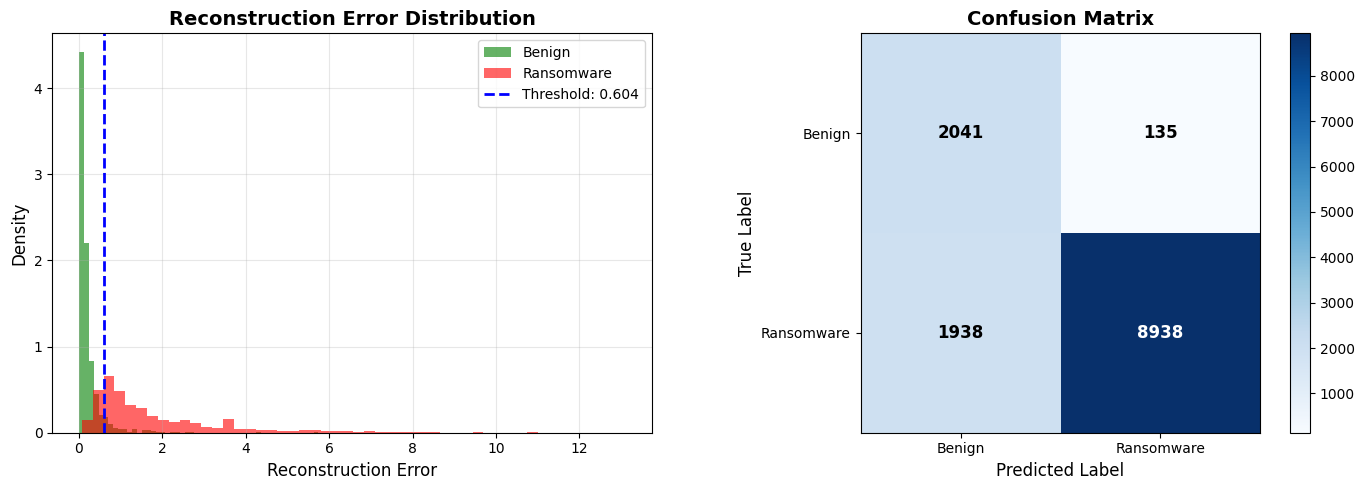


----------------------------------------
Sample Predictions (first 10 test samples):
----------------------------------------
Sample 1: True=Benign     Predicted=Benign     Error=0.1245 Confidence=20.6%    ✓ CORRECT
Sample 2: True=Benign     Predicted=Benign     Error=0.0164 Confidence=2.7%     ✓ CORRECT
Sample 3: True=Benign     Predicted=Ransomware Error=0.6785 Confidence=100.0%   ✗ WRONG
Sample 4: True=Benign     Predicted=Benign     Error=0.1046 Confidence=17.3%    ✓ CORRECT
Sample 5: True=Benign     Predicted=Benign     Error=0.1768 Confidence=29.3%    ✓ CORRECT
Sample 6: True=Benign     Predicted=Benign     Error=0.1045 Confidence=17.3%    ✓ CORRECT
Sample 7: True=Benign     Predicted=Benign     Error=0.0675 Confidence=11.2%    ✓ CORRECT
Sample 8: True=Benign     Predicted=Benign     Error=0.0278 Confidence=4.6%     ✓ CORRECT
Sample 9: True=Benign     Predicted=Benign     Error=0.0269 Confidence=4.5%     ✓ CORRECT
Sample 10: True=Benign     Predicted=Benign     Error=0.4402 Conf

In [20]:
# Cell 9: Run Detection on Test Set
print("\n" + "="*60)
print("RUNNING RANSOMWARE DETECTION")
print("="*60)

# Check if we have the required variables
if 'cae' in locals() and 'X_test' in locals() and 'y_test' in locals():
    try:
        # Predict on test data
        print("Running predictions on test set...")
        results = cae.predict(X_test, return_details=True)
        
        # Extract results based on what the method returns
        predictions = results['predictions']
        
        # Check if confidence scores exist
        if 'confidence' in results:
            confidence = results['confidence']
        elif 'anomaly_scores' in results:
            confidence = results['anomaly_scores']
        else:
            confidence = None
        
        reconstruction_errors = results['reconstruction_errors']
        threshold = results['threshold']
        
        # Calculate metrics
        from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
        
        accuracy = accuracy_score(y_test, predictions)
        precision = precision_score(y_test, predictions, zero_division=0)
        recall = recall_score(y_test, predictions, zero_division=0)
        f1 = f1_score(y_test, predictions, zero_division=0)
        cm = confusion_matrix(y_test, predictions)
        
        print(f"\nDetection Threshold: {threshold:.6f}")
        print(f"\nPerformance Metrics:")
        print(f"  Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
        print(f"  Precision: {precision:.4f} ({precision*100:.2f}%)")
        print(f"  Recall:    {recall:.4f} ({recall*100:.2f}%)")
        print(f"  F1-Score:  {f1:.4f}")
        
        # Calculate additional metrics
        tn, fp, fn, tp = cm.ravel()
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # Same as recall
        tnr = tn / (tn + fp) if (tn + fp) > 0 else 0
        
        print(f"\nConfusion Matrix:")
        print(f"  True Negatives (TN): {tn:5d} - Benign correctly identified")
        print(f"  False Positives (FP): {fp:5d} - Benign misclassified as ransomware")
        print(f"  False Negatives (FN): {fn:5d} - Ransomware misclassified as benign")
        print(f"  True Positives (TP): {tp:5d} - Ransomware correctly identified")
        
        print(f"\nAdditional Metrics:")
        print(f"  False Positive Rate (FPR): {fpr:.4f} ({fpr*100:.2f}%)")
        print(f"  False Negative Rate (FNR): {fnr:.4f} ({fnr*100:.2f}%)")
        print(f"  True Positive Rate (TPR/Recall): {tpr:.4f} ({tpr*100:.2f}%)")
        print(f"  True Negative Rate (TNR): {tnr:.4f} ({tnr*100:.2f}%)")
        
        # Detailed classification report
        print("\n" + "-"*40)
        print("Detailed Classification Report:")
        print("-"*40)
        print(classification_report(y_test, predictions, 
                                    target_names=['Benign', 'Ransomware']))
        
        # Visualize results
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Plot 1: Reconstruction errors distribution
        axes[0].hist(reconstruction_errors[y_test == 0], bins=50, alpha=0.6, 
                    label='Benign', color='green', density=True)
        axes[0].hist(reconstruction_errors[y_test == 1], bins=50, alpha=0.6, 
                    label='Ransomware', color='red', density=True)
        axes[0].axvline(threshold, color='blue', linestyle='--', 
                       linewidth=2, label=f'Threshold: {threshold:.3f}')
        axes[0].set_xlabel('Reconstruction Error', fontsize=12)
        axes[0].set_ylabel('Density', fontsize=12)
        axes[0].set_title('Reconstruction Error Distribution', fontsize=14, fontweight='bold')
        axes[0].legend(fontsize=10)
        axes[0].grid(True, alpha=0.3)
        
        # Plot 2: Confusion Matrix Heatmap
        im = axes[1].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        axes[1].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
        
        # Add text annotations
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                axes[1].text(j, i, format(cm[i, j], 'd'),
                           ha="center", va="center",
                           color="white" if cm[i, j] > thresh else "black",
                           fontsize=12, fontweight='bold')
        
        tick_marks = np.arange(2)
        axes[1].set_xticks(tick_marks)
        axes[1].set_yticks(tick_marks)
        axes[1].set_xticklabels(['Benign', 'Ransomware'], fontsize=10)
        axes[1].set_yticklabels(['Benign', 'Ransomware'], fontsize=10)
        axes[1].set_ylabel('True Label', fontsize=12)
        axes[1].set_xlabel('Predicted Label', fontsize=12)
        
        plt.colorbar(im, ax=axes[1])
        plt.tight_layout()
        plt.savefig('detection_results.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Print sample predictions
        print("\n" + "-"*40)
        print("Sample Predictions (first 10 test samples):")
        print("-"*40)
        
        for i in range(min(10, len(X_test))):
            true_label = "Ransomware" if y_test[i] == 1 else "Benign"
            pred_label = "Ransomware" if predictions[i] == 1 else "Benign"
            confidence_val = confidence[i] if confidence is not None else "N/A"
            
            status = "✓ CORRECT" if predictions[i] == y_test[i] else "✗ WRONG"
            
            print(f"Sample {i+1}: True={true_label:<10} Predicted={pred_label:<10} "
                  f"Error={reconstruction_errors[i]:.4f} Confidence={confidence_val if isinstance(confidence_val, str) else f'{confidence_val:.1f}%':<8} {status}")
        
        # Save results to file
        import json
        import datetime
        
        results_summary = {
            'timestamp': datetime.datetime.now().isoformat(),
            'threshold': float(threshold),
            'accuracy': float(accuracy),
            'precision': float(precision),
            'recall': float(recall),
            'f1_score': float(f1),
            'confusion_matrix': cm.tolist(),
            'test_set_size': int(len(X_test)),
            'benign_samples': int(np.sum(y_test == 0)),
            'ransomware_samples': int(np.sum(y_test == 1)),
            'false_positive_rate': float(fpr),
            'false_negative_rate': float(fnr)
        }
        
        with open('detection_results.json', 'w') as f:
            json.dump(results_summary, f, indent=2)
        
        print("\n✓ Detection results saved to 'detection_results.json'")
        
    except Exception as e:
        print(f"Error during detection: {e}")
        print("\nTrying alternative prediction method...")
        
        # Try direct method
        try:
            reconstruction_errors = cae.get_reconstruction_error(X_test)
            predictions = (reconstruction_errors > cae.threshold).astype(int)
            
            # Calculate metrics
            from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
            
            accuracy = accuracy_score(y_test, predictions)
            precision = precision_score(y_test, predictions, zero_division=0)
            recall = recall_score(y_test, predictions, zero_division=0)
            f1 = f1_score(y_test, predictions, zero_division=0)
            
            print(f"\nAlternative method results:")
            print(f"Accuracy: {accuracy:.4f}")
            print(f"Precision: {precision:.4f}")
            print(f"Recall: {recall:.4f}")
            print(f"F1-Score: {f1:.4f}")
            
        except Exception as e2:
            print(f"Alternative method also failed: {e2}")
            
else:
    print("Error: Required variables not found.")
    print("Please ensure the following variables are available:")
    print("  - cae: trained ContractiveAutoencoder object")
    print("  - X_test: test features")
    print("  - y_test: test labels")
    
    # Show what's available
    print("\nAvailable variables:")
    vars_to_check = ['cae', 'X_test', 'y_test', 'X_benign_train', 'history']
    for var in vars_to_check:
        if var in locals():
            print(f"  ✓ {var}: available")
        else:
            print(f"  ✗ {var}: not available")


VISUALIZING DETECTION RESULTS (OPTIMIZED)
Test set size: 13052 samples
Calculating metrics...
✓ Metrics calculated successfully!
  Accuracy:  0.7219
  Precision: 0.9897
  Recall:    0.6732
  F1-Score:  0.8014
Creating histogram...
Creating scatter plot...
Creating confusion matrix...
Creating metrics chart...
Saving figure...
Showing plot...


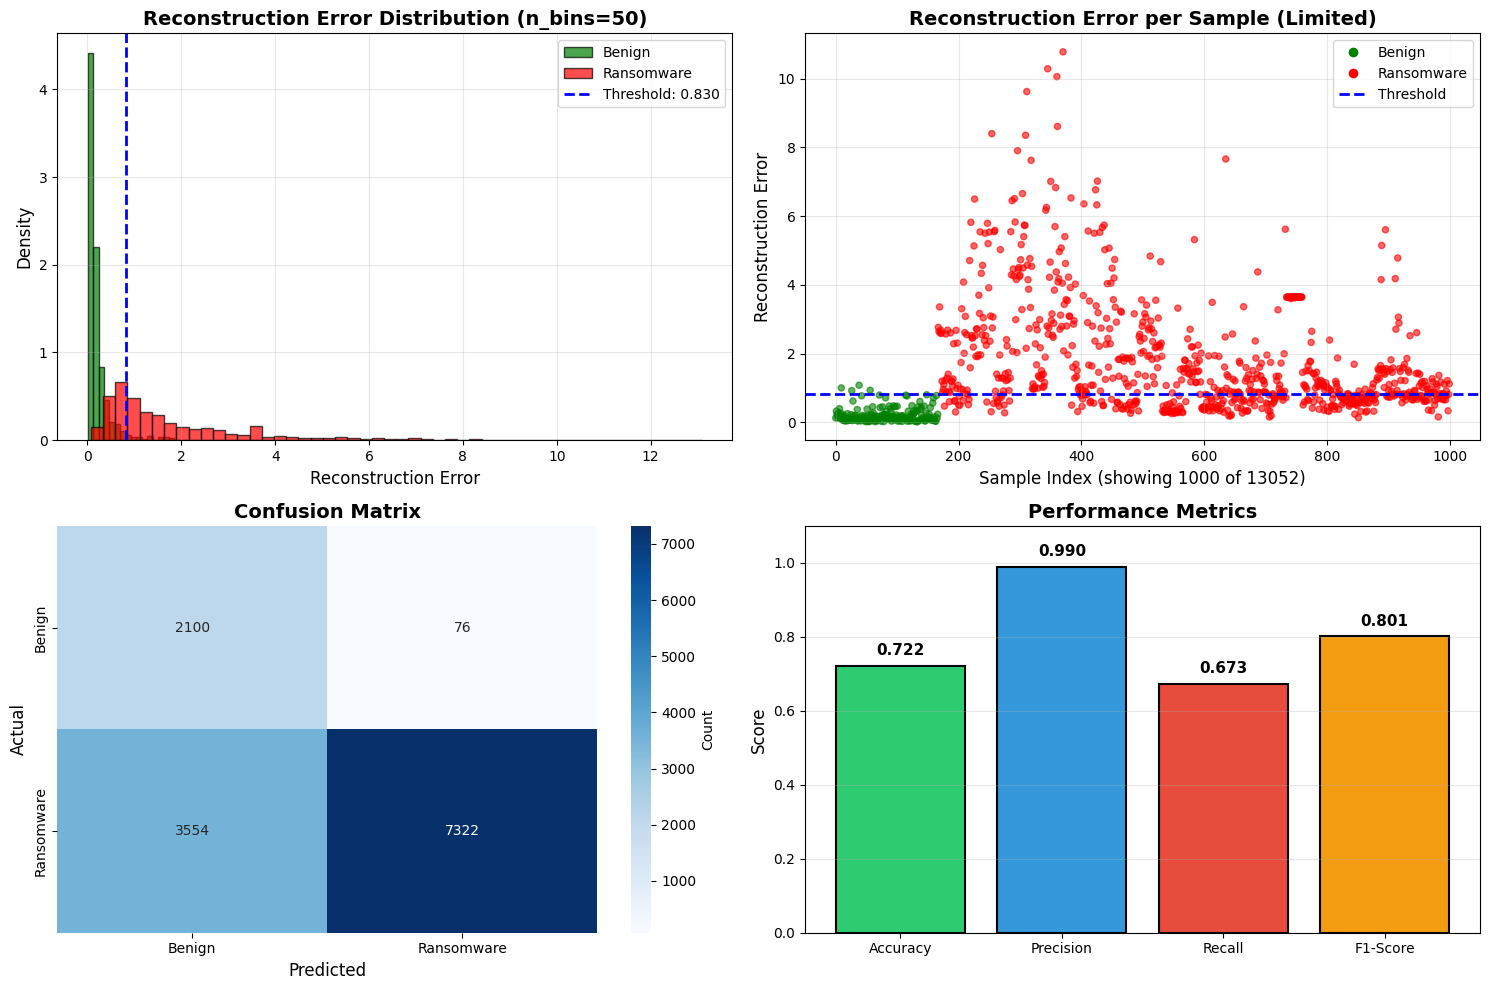


DETECTION RESULTS SUMMARY
Detection Threshold: 0.830061

Reconstruction Error Statistics:
  Overall - Mean: 1.571491, Std: 1.680592
            Min: 0.010504, Max: 13.083476
  Benign - Mean: 0.212068, Above threshold: 76/2176 (3.5%)
  Ransomware - Mean: 1.843475, Above threshold: 7322/10876 (67.3%)

Performance Metrics:
  Accuracy:  0.7219 (72.19%)
  Precision: 0.9897 (98.97%)
  Recall:    0.6732 (67.32%)
  F1-Score:  0.8014

Confusion Matrix:
  True Negatives (Benign): 2100
  False Positives: 76
  False Negatives: 3554
  True Positives (Ransomware): 7322

✓ Results saved to 'detection_summary.json'
✓ Visualization saved to 'detection_results_optimized.png'


In [21]:
# Cell 10: Optimized Visualization
print("\n" + "="*60)
print("VISUALIZING DETECTION RESULTS (OPTIMIZED)")
print("="*60)

import matplotlib.pyplot as plt
import seaborn as sns

# Check if we have basic components
if 'cae' not in locals() or 'X_test' not in locals() or 'y_test' not in locals():
    print("ERROR: Missing basic components (cae, X_test, or y_test).")
    print("Please run the training and testing cells first.")
else:
    print(f"Test set size: {len(X_test)} samples")
    print("Calculating metrics...")
    
    # Calculate only what we need
    reconstruction_errors = cae.get_reconstruction_error(X_test)
    threshold = cae.threshold
    predictions = (reconstruction_errors > threshold).astype(int)
    
    # Calculate metrics
    from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
    
    cm = confusion_matrix(y_test, predictions)
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, zero_division=0)
    recall = recall_score(y_test, predictions, zero_division=0)
    f1 = f1_score(y_test, predictions, zero_division=0)
    
    print("✓ Metrics calculated successfully!")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    
    # OPTIMIZATION 1: Limit number of samples for scatter plot
    max_scatter_samples = 1000  # Limit scatter plot to 1000 points
    if len(reconstruction_errors) > max_scatter_samples:
        indices = np.linspace(0, len(reconstruction_errors)-1, max_scatter_samples, dtype=int)
        plot_errors = reconstruction_errors[indices]
        plot_y_test = y_test[indices]
    else:
        plot_errors = reconstruction_errors
        plot_y_test = y_test
    
    # Create figure
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Reconstruction Error Distribution (OPTIMIZED)
    print("Creating histogram...")
    benign_errors = reconstruction_errors[y_test == 0]
    ransomware_errors = reconstruction_errors[y_test == 1]
    
    # Use fewer bins for large datasets
    n_bins = min(50, min(len(benign_errors), len(ransomware_errors)) // 10)
    n_bins = max(20, n_bins)  # At least 20 bins
    
    axes[0, 0].hist(benign_errors, bins=n_bins, alpha=0.7, 
                    label='Benign', color='green', edgecolor='black', density=True)
    axes[0, 0].hist(ransomware_errors, bins=n_bins, alpha=0.7, 
                    label='Ransomware', color='red', edgecolor='black', density=True)
    axes[0, 0].axvline(threshold, color='blue', linestyle='--', linewidth=2, label=f'Threshold: {threshold:.3f}')
    axes[0, 0].set_xlabel('Reconstruction Error', fontsize=12)
    axes[0, 0].set_ylabel('Density', fontsize=12)
    axes[0, 0].set_title(f'Reconstruction Error Distribution (n_bins={n_bins})', fontsize=14, fontweight='bold')
    axes[0, 0].legend(fontsize=10)
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Scatter Plot (OPTIMIZED - limited points)
    print("Creating scatter plot...")
    colors = ['green' if label == 0 else 'red' for label in plot_y_test]
    
    # Use smaller markers for many points
    marker_size = max(1, 30 - len(plot_errors) // 100)
    
    # Create scatter with color array (much faster than loop)
    scatter = axes[0, 1].scatter(range(len(plot_errors)), plot_errors, 
                                c=colors, alpha=0.6, s=marker_size)
    axes[0, 1].axhline(threshold, color='blue', linestyle='--', linewidth=2, label='Threshold')
    axes[0, 1].set_xlabel(f'Sample Index (showing {len(plot_errors)} of {len(reconstruction_errors)})', fontsize=12)
    axes[0, 1].set_ylabel('Reconstruction Error', fontsize=12)
    axes[0, 1].set_title('Reconstruction Error per Sample (Limited)', fontsize=14, fontweight='bold')
    
    # Create custom legend (faster than individual labels)
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=8, label='Benign'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='Ransomware'),
        Line2D([0], [0], color='blue', linestyle='--', linewidth=2, label='Threshold')
    ]
    axes[0, 1].legend(handles=legend_elements, fontsize=10)
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Confusion Matrix Heatmap
    print("Creating confusion matrix...")
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0],
                xticklabels=['Benign', 'Ransomware'],
                yticklabels=['Benign', 'Ransomware'],
                cbar_kws={'label': 'Count'})
    axes[1, 0].set_xlabel('Predicted', fontsize=12)
    axes[1, 0].set_ylabel('Actual', fontsize=12)
    axes[1, 0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
    
    # 4. Performance Metrics Bar Chart
    print("Creating metrics chart...")
    metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    metrics_values = [accuracy, precision, recall, f1]
    colors = ['#2ecc71', '#3498db', '#e74c3c', '#f39c12']
    
    bars = axes[1, 1].bar(metrics_names, metrics_values, color=colors, 
                         edgecolor='black', linewidth=1.5)
    axes[1, 1].set_ylabel('Score', fontsize=12)
    axes[1, 1].set_title('Performance Metrics', fontsize=14, fontweight='bold')
    axes[1, 1].set_ylim([0, 1.1])
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar, value in zip(bars, metrics_values):
        height = bar.get_height()
        axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                       f'{value:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    print("Saving figure...")
    plt.savefig('detection_results_optimized.png', dpi=150, bbox_inches='tight')  # Lower DPI for faster save
    print("Showing plot...")
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*60)
    print("DETECTION RESULTS SUMMARY")
    print("="*60)
    print(f"Detection Threshold: {threshold:.6f}")
    print(f"\nReconstruction Error Statistics:")
    print(f"  Overall - Mean: {reconstruction_errors.mean():.6f}, Std: {reconstruction_errors.std():.6f}")
    print(f"            Min: {reconstruction_errors.min():.6f}, Max: {reconstruction_errors.max():.6f}")
    print(f"  Benign - Mean: {benign_errors.mean():.6f}, Above threshold: {np.sum(benign_errors > threshold)}/{len(benign_errors)} ({np.sum(benign_errors > threshold)/len(benign_errors)*100:.1f}%)")
    print(f"  Ransomware - Mean: {ransomware_errors.mean():.6f}, Above threshold: {np.sum(ransomware_errors > threshold)}/{len(ransomware_errors)} ({np.sum(ransomware_errors > threshold)/len(ransomware_errors)*100:.1f}%)")
    
    print(f"\nPerformance Metrics:")
    print(f"  Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"  Precision: {precision:.4f} ({precision*100:.2f}%)")
    print(f"  Recall:    {recall:.4f} ({recall*100:.2f}%)")
    print(f"  F1-Score:  {f1:.4f}")
    
    print(f"\nConfusion Matrix:")
    tn, fp, fn, tp = cm.ravel()
    print(f"  True Negatives (Benign): {tn}")
    print(f"  False Positives: {fp}")
    print(f"  False Negatives: {fn}")
    print(f"  True Positives (Ransomware): {tp}")
    
    # Save results to file
    import json
    import datetime
    
    results = {
        'timestamp': datetime.datetime.now().isoformat(),
        'threshold': float(threshold),
        'accuracy': float(accuracy),
        'precision': float(precision),
        'recall': float(recall),
        'f1_score': float(f1),
        'confusion_matrix': cm.tolist(),
        'reconstruction_error_stats': {
            'overall_mean': float(reconstruction_errors.mean()),
            'overall_std': float(reconstruction_errors.std()),
            'overall_min': float(reconstruction_errors.min()),
            'overall_max': float(reconstruction_errors.max()),
            'benign_mean': float(benign_errors.mean()),
            'benign_above_threshold': int(np.sum(benign_errors > threshold)),
            'benign_total': int(len(benign_errors)),
            'ransomware_mean': float(ransomware_errors.mean()),
            'ransomware_above_threshold': int(np.sum(ransomware_errors > threshold)),
            'ransomware_total': int(len(ransomware_errors))
        }
    }
    
    with open('detection_summary.json', 'w') as f:
        json.dump(results, f, indent=2)
    
    print("\n✓ Results saved to 'detection_summary.json'")
    print("✓ Visualization saved to 'detection_results_optimized.png'")


MISCLASSIFICATION ANALYSIS
Missing required variables. Need: ['predictions', 'y_test', 'reconstruction_errors', 'threshold']
Available: []

Calculating predictions...
✓ Predictions calculated successfully!

Total misclassified: 3835 / 13052 (29.38%)

False Positives: 86 (0.66%)
False Negatives: 3749 (28.72%)

False Positive Rate (FPR): 0.0395 (3.95%)
False Negative Rate (FNR): 0.3447 (34.47%)

Sample False Positives (First 5):
  1. Index    10: Error=1.345445 (threshold=1.138623), Confidence=100.0%, Error/Threshold ratio=1.18
  2. Index    29: Error=2.735877 (threshold=1.138623), Confidence=100.0%, Error/Threshold ratio=2.40
  3. Index    37: Error=4.252457 (threshold=1.138623), Confidence=100.0%, Error/Threshold ratio=3.73
  4. Index    41: Error=1.701553 (threshold=1.138623), Confidence=100.0%, Error/Threshold ratio=1.49
  5. Index    53: Error=3.991909 (threshold=1.138623), Confidence=100.0%, Error/Threshold ratio=3.51

Sample False Negatives (First 5):
  1. Index  2176: Error=0.53

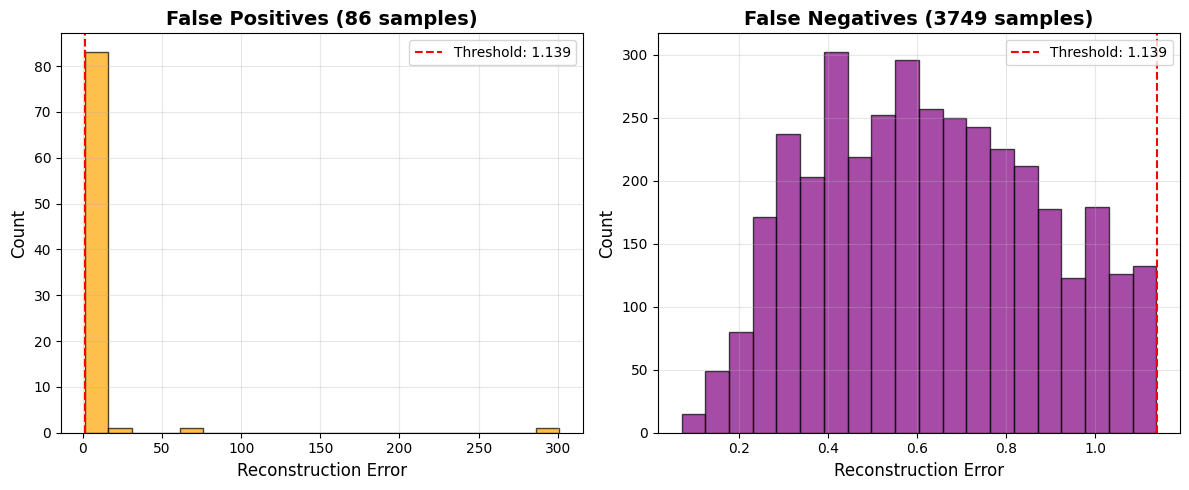


✓ Misclassification visualization saved to 'misclassification_analysis.png'

----------------------------------------
RECOMMENDATIONS
----------------------------------------
⚠ High number of False Negatives detected.
  Recommendation: Consider decreasing the threshold to catch more ransomware.
  Current threshold: 1.138623
  Suggested adjustment: 0.910898 (-20%)


In [13]:
# Cell 11: Analyze Misclassifications
print("\n" + "="*60)
print("MISCLASSIFICATION ANALYSIS")
print("="*60)

# Check if we have the required variables
required_vars = ['predictions', 'y_test', 'reconstruction_errors', 'threshold']
available_vars = [var for var in required_vars if var in locals()]

if len(available_vars) < len(required_vars):
    print(f"Missing required variables. Need: {required_vars}")
    print(f"Available: {available_vars}")
    
    # Try to calculate if we have basic components
    if 'cae' in locals() and 'X_test' in locals() and 'y_test' in locals():
        print("\nCalculating predictions...")
        try:
            # Get predictions
            results = cae.predict(X_test, return_details=True)
            predictions = results['predictions']
            reconstruction_errors = results['reconstruction_errors']
            threshold = results['threshold']
            
            # Check if confidence is available
            if 'confidence' in results:
                confidence = results['confidence']
            elif 'anomaly_scores' in results:
                confidence = results['anomaly_scores']
            else:
                confidence = None
            
            print("✓ Predictions calculated successfully!")
        except Exception as e:
            print(f"Error calculating predictions: {e}")
    else:
        print("\nCannot proceed. Please run detection first.")
else:
    print(f"✓ All required variables available")

# Now check if we have predictions and y_test
if 'predictions' in locals() and 'y_test' in locals():
    # Find misclassified samples
    misclassified = predictions != y_test
    n_misclassified = np.sum(misclassified)
    
    print(f"\nTotal misclassified: {n_misclassified} / {len(y_test)} ({n_misclassified/len(y_test)*100:.2f}%)")
    
    if n_misclassified > 0:
        # False Positives (Benign classified as Ransomware)
        false_positives = (predictions == 1) & (y_test == 0)
        n_fp = np.sum(false_positives)
        
        # False Negatives (Ransomware classified as Benign)
        false_negatives = (predictions == 0) & (y_test == 1)
        n_fn = np.sum(false_negatives)
        
        print(f"\nFalse Positives: {n_fp} ({n_fp/len(y_test)*100:.2f}%)")
        print(f"False Negatives: {n_fn} ({n_fn/len(y_test)*100:.2f}%)")
        
        # Calculate FPR and FNR
        if n_fp > 0 or 'y_test' in locals():
            tn = np.sum((predictions == 0) & (y_test == 0))
            fp = n_fp
            fn = n_fn
            tp = np.sum((predictions == 1) & (y_test == 1))
            
            fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
            fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
            
            print(f"\nFalse Positive Rate (FPR): {fpr:.4f} ({fpr*100:.2f}%)")
            print(f"False Negative Rate (FNR): {fnr:.4f} ({fnr*100:.2f}%)")
        
        # Show some examples if we have reconstruction errors
        if 'reconstruction_errors' in locals() and 'threshold' in locals():
            if n_fp > 0:
                print(f"\nSample False Positives (First 5):")
                fp_indices = np.where(false_positives)[0][:5]
                for i, idx in enumerate(fp_indices):
                    error = reconstruction_errors[idx]
                    conf = confidence[idx] if 'confidence' in locals() and confidence is not None else "N/A"
                    print(f"  {i+1}. Index {idx:5d}: Error={error:.6f} (threshold={threshold:.6f}), "
                          f"Confidence={conf if isinstance(conf, str) else f'{conf:.1f}%'}, "
                          f"Error/Threshold ratio={error/threshold:.2f}")
            
            if n_fn > 0:
                print(f"\nSample False Negatives (First 5):")
                fn_indices = np.where(false_negatives)[0][:5]
                for i, idx in enumerate(fn_indices):
                    error = reconstruction_errors[idx]
                    conf = confidence[idx] if 'confidence' in locals() and confidence is not None else "N/A"
                    print(f"  {i+1}. Index {idx:5d}: Error={error:.6f} (threshold={threshold:.6f}), "
                          f"Confidence={conf if isinstance(conf, str) else f'{conf:.1f}%'}, "
                          f"Error/Threshold ratio={error/threshold:.2f}")
        
        # Analyze error distributions for misclassifications
        if 'reconstruction_errors' in locals():
            print(f"\n" + "-"*40)
            print("ERROR ANALYSIS FOR MISCLASSIFICATIONS")
            print("-"*40)
            
            fp_errors = reconstruction_errors[false_positives] if n_fp > 0 else np.array([])
            fn_errors = reconstruction_errors[false_negatives] if n_fn > 0 else np.array([])
            
            if len(fp_errors) > 0:
                print(f"False Positive Errors:")
                print(f"  Mean: {fp_errors.mean():.6f}")
                print(f"  Std:  {fp_errors.std():.6f}")
                print(f"  Min:  {fp_errors.min():.6f}")
                print(f"  Max:  {fp_errors.max():.6f}")
                print(f"  All above threshold? {np.all(fp_errors > threshold)}")
            
            if len(fn_errors) > 0:
                print(f"\nFalse Negative Errors:")
                print(f"  Mean: {fn_errors.mean():.6f}")
                print(f"  Std:  {fn_errors.std():.6f}")
                print(f"  Min:  {fn_errors.min():.6f}")
                print(f"  Max:  {fn_errors.max():.6f}")
                print(f"  All below threshold? {np.all(fn_errors <= threshold)}")
        
        # Visualize misclassification errors
        try:
            import matplotlib.pyplot as plt
            
            if n_fp > 0 or n_fn > 0:
                fig, axes = plt.subplots(1, 2, figsize=(12, 5))
                
                # Plot FP errors
                if n_fp > 0:
                    fp_errors = reconstruction_errors[false_positives]
                    axes[0].hist(fp_errors, bins=20, alpha=0.7, color='orange', edgecolor='black')
                    axes[0].axvline(threshold, color='red', linestyle='--', label=f'Threshold: {threshold:.3f}')
                    axes[0].set_xlabel('Reconstruction Error', fontsize=12)
                    axes[0].set_ylabel('Count', fontsize=12)
                    axes[0].set_title(f'False Positives ({n_fp} samples)', fontsize=14, fontweight='bold')
                    axes[0].legend()
                    axes[0].grid(True, alpha=0.3)
                
                # Plot FN errors
                if n_fn > 0:
                    fn_errors = reconstruction_errors[false_negatives]
                    axes[1].hist(fn_errors, bins=20, alpha=0.7, color='purple', edgecolor='black')
                    axes[1].axvline(threshold, color='red', linestyle='--', label=f'Threshold: {threshold:.3f}')
                    axes[1].set_xlabel('Reconstruction Error', fontsize=12)
                    axes[1].set_ylabel('Count', fontsize=12)
                    axes[1].set_title(f'False Negatives ({n_fn} samples)', fontsize=14, fontweight='bold')
                    axes[1].legend()
                    axes[1].grid(True, alpha=0.3)
                
                plt.tight_layout()
                plt.savefig('misclassification_analysis.png', dpi=150, bbox_inches='tight')
                plt.show()
                print("\n✓ Misclassification visualization saved to 'misclassification_analysis.png'")
        
        except Exception as e:
            print(f"\nNote: Could not create misclassification visualization: {e}")
        
        # Provide recommendations based on misclassifications
        print(f"\n" + "-"*40)
        print("RECOMMENDATIONS")
        print("-"*40)
        
        if n_fp > n_fn * 2:
            print("⚠ High number of False Positives detected.")
            print("  Recommendation: Consider increasing the threshold to reduce false alarms.")
            print(f"  Current threshold: {threshold:.6f}")
            print(f"  Suggested adjustment: {threshold * 1.2:.6f} (+20%)")
        
        elif n_fn > n_fp * 2:
            print("⚠ High number of False Negatives detected.")
            print("  Recommendation: Consider decreasing the threshold to catch more ransomware.")
            print(f"  Current threshold: {threshold:.6f}")
            print(f"  Suggested adjustment: {threshold * 0.8:.6f} (-20%)")
        
        elif n_fp > 0 and n_fn > 0:
            print("✓ Balanced misclassifications.")
            print("  Both false positives and false negatives are present but not excessive.")
            print("  Consider collecting more training data or tuning model hyperparameters.")
        
        else:
            print("✓ Excellent performance! No misclassifications detected.")
    
    else:
        print("\n✓ Perfect classification! No misclassifications.")
        
else:
    print("\nCannot perform misclassification analysis.")
    print("Need predictions and y_test variables.")

In [ ]:
# Cell 12: Save the Trained Model
if label_col:
    model_path = 'ransomware_cae_model.h5'
    cae.save_model(model_path)
    
    print("\n" + "="*60)
    print("MODEL SAVED SUCCESSFULLY")
    print("="*60)
    print(f"Model saved to: {model_path}")
    print(f"Threshold saved to: {model_path}_threshold.npy")
    
    # Save predictions to CSV
    results_df = pd.DataFrame({
        'true_label': y_test,
        'predicted_label': predictions,
        'reconstruction_error': reconstruction_errors,
        'confidence': confidence
    })
    results_df.to_csv('detection_results.csv', index=False)
    print(f"Detection results saved to: detection_results.csv")

# Cell 13: Load Model and Make New Predictions (Example)
"""
# UNCOMMENT TO LOAD A SAVED MODEL AND MAKE PREDICTIONS

# Load the saved model
cae_loaded = ContractiveAutoencoder(input_dim=X.shape[1])
cae_loaded.load_model('ransomware_cae_model.h5')

# Load new data (update path to your new CSV file)
new_data = pd.read_csv('new_ransomware_data.csv')

# Preprocess new data (remove label if present)
if label_col in new_data.columns:
    X_new = new_data.drop(columns=[label_col]).values
    y_new = new_data[label_col].values
else:
    X_new = new_data.values
    y_new = None

# Make predictions
new_results = cae_loaded.predict(X_new)

print("Predictions on new data:")
for i in range(min(10, len(X_new))):
    pred = 'RANSOMWARE' if new_results['predictions'][i] == 1 else 'BENIGN'
    print(f"Sample {i+1}: {pred} (Error: {new_results['reconstruction_errors'][i]:.6f}, "
          f"Confidence: {new_results['confidence'][i]:.1f}%)")

# If true labels are available, evaluate
if y_new is not None:
    acc = accuracy_score(y_new, new_results['predictions'])
    print(f"\nAccuracy on new data: {acc:.4f}")
"""

print("\n" + "="*60)
print("NOTEBOOK COMPLETED!")
print("="*60)
print("\nSummary:")
print("- Model trained on benign samples only")
print("- Ransomware detected based on reconstruction error")
print("- All visualizations saved as PNG files")
print("- Model and results saved to disk")
print("\nTo use the model on new data, uncomment and run Cell 13")
